# Pleiades Grey Paper
## An interactive data exploration framework
<p>By: Dominic Zygadlo</p>

import dependencies

In [10]:
import scipy.stats as st
from backEnd import plots
from palmerpenguins import load_penguins
import importlib
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb
from sklearn import preprocessing as prep
import pandas as pd
import numpy as np

Begin with the importing of data returning basic statistics about each feature. If there are missing values, we will need to remove those rows accordingly.

In [11]:

penguins = load_penguins()
penguins = penguins.dropna()

Next, we display all descriptive tables and plots for each of the features. 

In [12]:
importlib.reload(plots)
for column in penguins.columns:
    plots.descriptiveStatistics(penguins, column).show()

Now, we display all of the descriptive distributions for each of the continuous features (i.e. displaying numerical features with categorical subgroups)

In [13]:
importlib.reload(plots)
quantitative = [column for column in penguins.columns if not plots.isQualitative(penguins, column)]
qualititative = [column for column in penguins.columns if plots.isQualitative(penguins, column)]
for feature in quantitative:
    plots.descriptiveDistributions(penguins, feature, qualititative).show()

Afterwards, we display heat maps to visualize the correlation coefficients for each of the feature combinations.

SHAP with XGBOOST

In [14]:
shap.initjs()

In [22]:
features = penguins[quantitative]
specs = {'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 0}
outcomes = penguins['species']
outcomes = [specs[item] for item in outcomes]

# here would precede logic that accommodates feature sets and multiple outcome variables
x_train, x_val, y_train, y_val = train_test_split(features, outcomes, test_size=0.3)
train_data = xgb.DMatrix(x_train, label=y_train)
val_data = xgb.DMatrix(x_val, label=y_val)

params = {
    'eta': 0.5,
    'max_depth': 5,
    'objective': 'binary:logistic',
    'base_score': np.mean(y_train),
    'eval_metric': ['logloss', 'auc']
}

model = xgb.train(params, train_data, 200, [(train_data,'train'),(val_data,'valid')], early_stopping_rounds=10, verbose_eval=5)

xgb_train = xgb.cv(params, train_data, 100, 5, metrics=('auc','logloss'), early_stopping_rounds=10, verbose_eval=20, seed=7)
xgb_val = xgb.cv(params, val_data, 200, 5, metrics=('auc','logloss'), early_stopping_rounds=10, verbose_eval=20, seed=7)

xgb_val.head()

[0]	train-logloss:0.29260	train-auc:0.99976	valid-logloss:0.32583	valid-auc:0.97199
[5]	train-logloss:0.03303	train-auc:1.00000	valid-logloss:0.15025	valid-auc:0.97199
[10]	train-logloss:0.01088	train-auc:1.00000	valid-logloss:0.12115	valid-auc:0.99660
[15]	train-logloss:0.00856	train-auc:1.00000	valid-logloss:0.11091	valid-auc:0.99660
[16]	train-logloss:0.00856	train-auc:1.00000	valid-logloss:0.11090	valid-auc:0.99660


,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std
0,0.991491,0.003262,0.342853,0.011203,0.957179,0.039681,0.375485,0.051175
1,0.999266,0.000396,0.213117,0.007952,0.974692,0.031042,0.258139,0.067841
2,0.999668,0.000365,0.143869,0.006167,0.991564,0.010347,0.179640,0.051810
3,1.000000,0.000000,0.103504,0.006542,0.991742,0.011815,0.143167,0.053957
4,1.000000,0.000000,0.076276,0.004568,0.991742,0.011815,0.124950,0.059951


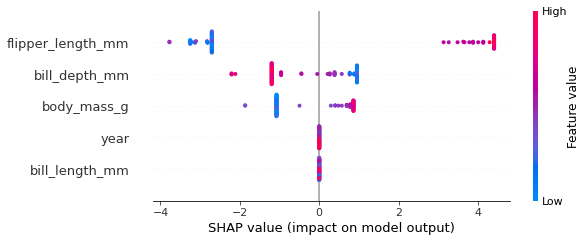

C:\Users\domin\anaconda3\envs\py3.7\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\domin\anaconda3\envs\py3.7\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning:

invalid value encountered in true_divide



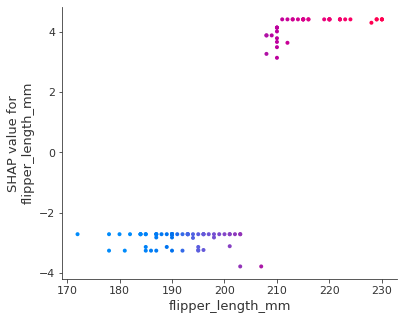

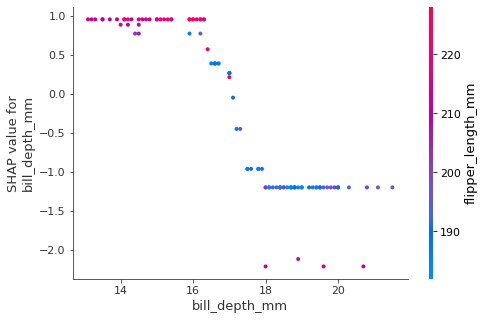

C:\Users\domin\anaconda3\envs\py3.7\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\domin\anaconda3\envs\py3.7\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning:

invalid value encountered in true_divide



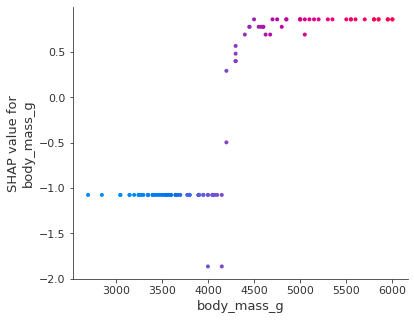

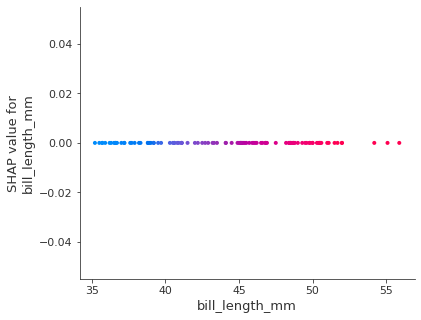

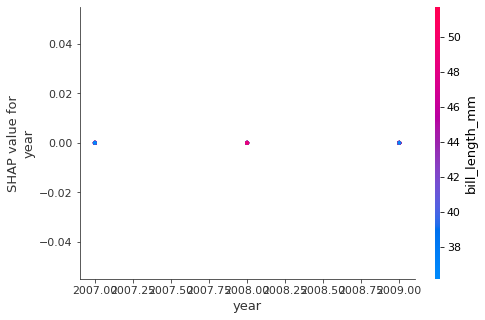

In [23]:
explainer = shap.TreeExplainer(model)
xgb_shap_vals = explainer.shap_values(x_val)

#summary plot
shap.summary_plot(xgb_shap_vals, x_val)

#sort features by importance and display dependence plots
top_feats = np.argsort(-np.sum(np.abs(xgb_shap_vals), 0))

for i in range(len(features.columns)):
    shap.dependence_plot(top_feats[i], xgb_shap_vals, x_val)